In [91]:
# accelerate==0.29.3
# datasets==2.19.0
# diffusers==0.28.0
# einops==0.8.0
# Pillow==10.3.0
# torch==2.2.0
# torchvision==0.17.0
# tqdm==4.66.2
# transformers==4.40.1

!pip install pillow torchmetrics torchmetrics[image] torch-fidelity
!pip install -q --upgrade datasets fsspec
#  or, if you want to pin exactly the fixed version:
# !pip install -q datasets==2.14.7 fsspec==2023.9.2

# Dataset Generation


In [49]:
import pandas as pd, urllib.request, time, hashlib, json
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont

# ─────────────── CONFIG ────────────────
CSV_FILE        = "multilingual_data.csv"
OUT_DIR         = Path("data")
IMAGE_SIZE      = 128
IMAGES_PER_CHAR = 5                     # full-set duplicates

# mini-set for quick over-fit tests
MINI         = True
MINI_CODES   = ["0041","0641","0915"]
MINI_COPIES  = 10
# ───────────────────────────────────────

# 1⃣  Fonts (always download, no system fallback) ────────────────────────────
FONTS = {
    "latin"     : ("NotoSans-Regular.ttf",
                   "https://raw.githubusercontent.com/google/fonts/main/ofl/notosans/NotoSans-Regular.ttf"),
    "arabic"    : ("NotoNaskhArabic-Regular.ttf",
                   "https://raw.githubusercontent.com/google/fonts/main/ofl/notonaskharabic/NotoNaskhArabic-Regular.ttf"),
    "devanagari": ("NotoSansDevanagari-Regular.ttf",
                   "https://raw.githubusercontent.com/google/fonts/main/ofl/notosansdevanagari/NotoSansDevanagari-Regular.ttf"),
}
def download_ttf(fname, url):
    if Path(fname).exists() and Path(fname).stat().st_size > 1000:
        return
    print("↓", fname)
    req = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"})
    with urllib.request.urlopen(req) as r, open(fname, "wb") as f:
        f.write(r.read())
    if Path(fname).stat().st_size < 1000:
        raise RuntimeError(f"{fname} looks wrong (too small)")

for fname, url in FONTS.values():
    download_ttf(fname, url)

# 2⃣  Helpers ────────────────────────────────────────────────────────────────
def truetype_for(ch):
    cp = ord(ch)
    if   0x0600 <= cp <= 0x06FF: ttf = FONTS["arabic"][0]
    elif 0x0900 <= cp <= 0x097F or cp == 0x0950: ttf = FONTS["devanagari"][0]
    else: ttf = FONTS["latin"][0]
    return ImageFont.truetype(ttf, IMAGE_SIZE-28)

def render(ch, font):
    img, draw = Image.new("L", (IMAGE_SIZE, IMAGE_SIZE), 255), None
    draw = ImageDraw.Draw(img)
    w, h = draw.textbbox((0,0), ch, font=font)[2:]
    draw.text(((IMAGE_SIZE-w)//2, (IMAGE_SIZE-h)//2-8), ch, font=font, fill=0)
    return img

# 3⃣  Build dataset ──────────────────────────────────────────────────────────
def build():
    df = pd.read_csv(CSV_FILE, dtype=str)
    assert (df.apply(lambda r: int(r.Unicode,16)==ord(r.Character), axis=1)).all()

    if MINI:
        df = df[df.Unicode.isin(MINI_CODES)].reset_index(drop=True)
        duplicates = MINI_COPIES
    else:
        duplicates = IMAGES_PER_CHAR

    # repeat rows and give each copy its own suffix
    df = pd.concat([df]*duplicates).reset_index(drop=True)
    df["copy_id"]  = df.groupby("Unicode").cumcount()
    df["file_name"] = df.Unicode + "_" + df.copy_id.astype(str).str.zfill(3) + ".png"

    OUT_DIR.mkdir(exist_ok=True)

    # write each unique PNG once
    for row in df.drop_duplicates("file_name").itertuples(index=False):
        render(row.Character, truetype_for(row.Character)).save(OUT_DIR/row.file_name)

    df[["file_name","caption"]].to_json(OUT_DIR/"metadata.jsonl",
                                        orient="records", lines=True,
                                        force_ascii=False)
    df.to_csv(OUT_DIR/"char_dataset.csv", index=False)

    print(f"✅  {len(df)} rows, {df.file_name.nunique()} PNGs → {OUT_DIR}")

build()

✅  30 rows, 30 PNGs → data


# T5

In [65]:
import torch
import transformers
from typing import List
from transformers import T5Tokenizer, T5EncoderModel, T5Config
from einops import rearrange

transformers.logging.set_verbosity_error()

def exists(val):
    return val is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

# config

MAX_LENGTH = 256

DEFAULT_T5_NAME = 'google/t5-v1_1-base'

T5_CONFIGS = {}

# singleton globals

def get_tokenizer(name):
    tokenizer = T5Tokenizer.from_pretrained(name, model_max_length=MAX_LENGTH)
    return tokenizer

def get_model(name):
    model = T5EncoderModel.from_pretrained(name)
    return model

def get_model_and_tokenizer(name):
    global T5_CONFIGS

    if name not in T5_CONFIGS:
        T5_CONFIGS[name] = dict()
    if "model" not in T5_CONFIGS[name]:
        T5_CONFIGS[name]["model"] = get_model(name)
    if "tokenizer" not in T5_CONFIGS[name]:
        T5_CONFIGS[name]["tokenizer"] = get_tokenizer(name)

    return T5_CONFIGS[name]['model'], T5_CONFIGS[name]['tokenizer']

def get_encoded_dim(name):
    if name not in T5_CONFIGS:
        # avoids loading the model if we only want to get the dim
        config = T5Config.from_pretrained(name)
        T5_CONFIGS[name] = dict(config=config)
    elif "config" in T5_CONFIGS[name]:
        config = T5_CONFIGS[name]["config"]
    elif "model" in T5_CONFIGS[name]:
        config = T5_CONFIGS[name]["model"].config
    else:
        assert False
    return config.d_model

# encoding text

def t5_tokenize(
    texts: List[str],
    name = DEFAULT_T5_NAME
):
    t5, tokenizer = get_model_and_tokenizer(name)

    if torch.cuda.is_available():
        t5 = t5.cuda()

    device = next(t5.parameters()).device

    encoded = tokenizer.batch_encode_plus(
        texts,
        return_tensors = "pt",
        padding = 'longest',
        max_length = MAX_LENGTH,
        truncation = True
    )

    input_ids = encoded.input_ids.to(device)
    attn_mask = encoded.attention_mask.to(device)
    return input_ids, attn_mask

def t5_encode_tokenized_text(
    token_ids,
    attn_mask = None,
    pad_id = None,
    name = DEFAULT_T5_NAME
):
    assert exists(attn_mask) or exists(pad_id)
    t5, _ = get_model_and_tokenizer(name)

    attn_mask = default(attn_mask, lambda: (token_ids != pad_id).long())

    t5.eval()

    with torch.no_grad():
        output = t5(input_ids = token_ids, attention_mask = attn_mask)
        encoded_text = output.last_hidden_state.detach()

    attn_mask = attn_mask.bool()

    encoded_text = encoded_text.masked_fill(~rearrange(attn_mask, '... -> ... 1'), 0.) # just force all embeddings that is padding to be equal to 0.
    return encoded_text

def t5_encode_text(
    texts: List[str],
    name = DEFAULT_T5_NAME,
    return_attn_mask = False
):
    token_ids, attn_mask = t5_tokenize(texts, name = name)
    encoded_text = t5_encode_tokenized_text(token_ids, attn_mask = attn_mask, name = name)

    if return_attn_mask:
        attn_mask = attn_mask.bool()
        return encoded_text, attn_mask

    return encoded_text


# Utils

In [87]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torch.nn.utils.rnn import pad_sequence

from PIL import Image, ImageDraw, ImageFont

from diffusers.pipelines.pipeline_utils import DiffusionPipeline, ImagePipelineOutput
from typing import List, Optional, Tuple, Union
from diffusers.utils.torch_utils import randn_tensor


# Collator adjusted for local dataset
class Collator:
    def __init__(self, image_size, text_label, image_label, name, channels):
        self.text_label = text_label
        self.image_label = image_label
        self.name = name
        self.channels = channels
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
        ])

    def __call__(self, batch):
        texts = []
        masks = []
        images = []
        for item in batch:
            try:
                # Load image from local file
                image_path = 'data/'+item[self.image_label]  # Assuming this is a path to the image file
                with Image.open(image_path) as img:
                    image = self.transform(img.convert(self.channels))
            except Exception as e:
                print(f"Failed to process image {image_path}: {e}")
                continue

            # Encode the text
            text, mask = t5_encode_text(
                [item[self.text_label]],
                name=self.name,
                return_attn_mask=True
                )
            texts.append(torch.squeeze(text))
            masks.append(torch.squeeze(mask))
            images.append(image)

        if len(texts) == 0:
            return None

        # Are these strictly necessary?
        texts = pad_sequence(texts, True)
        masks = pad_sequence(masks, True)

        newbatch = []
        for i in range(len(texts)):
            newbatch.append((images[i], texts[i], masks[i]))

        return torch.utils.data.dataloader.default_collate(newbatch)


class GlyffuserPipeline(DiffusionPipeline):
    r'''
    Pipeline for text-to-image generation from the glyffuser model

    Parameters:
        unet (['UNet2DConditionModel'])
        scheduler (['SchedulerMixin'])
        text_encoder (['TextEncoder']) - T5 small
    '''
    def __init__(self, unet, scheduler):
        super().__init__()
        self.register_modules(
            unet=unet,
            scheduler=scheduler,
            )

    @torch.no_grad()
    def __call__(
        self,
        texts: List[str],
        text_encoder: str = "google-t5/t5-small",
        batch_size: int = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        num_inference_steps: int = 1000,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
    ) -> Union[ImagePipelineOutput, Tuple]:
        '''
        Docstring
        '''
        # Get text embeddings
        # Encode the text
        # text_embeddings = []
        # for text in texts:
        #     embedding = t5.t5_encode_text(text, name=text_encoder)
        #     text_embeddings.append(torch.squeeze(embedding))
        # text_embeddings = pad_sequence(text_embeddings, True)

        batch_size = len(texts)

        text_embeddings, masks = t5_encode_text(texts, name=text_encoder, return_attn_mask=True)

        # Sample gaussian noise to begin loop
        if isinstance(self.unet.config.sample_size, int):
            image_shape = (
                batch_size,
                self.unet.config.in_channels,
                self.unet.config.sample_size,
                self.unet.config.sample_size,
            )
        else:
            image_shape = (batch_size, self.unet.config.in_channels, *self.unet.config.sample_size)


        # if self.device.type == "mps": # MPS is apple silicon
        #     # randn does not work reproducibly on mps
        #     image = randn_tensor(image_shape, generator=generator)
        #     image = image.to(self.device)
        # else:
        image = randn_tensor(image_shape, generator=generator, device=self.device)

        # set step values
        self.scheduler.set_timesteps(num_inference_steps)

        for t in self.progress_bar(self.scheduler.timesteps):
            # 1. predict noise model_output
            model_output = self.unet(
                image,
                t,
                encoder_hidden_states=text_embeddings, # Add text encoding input
                encoder_attention_mask=masks, # Add attention mask
                return_dict=False
                )[0] # <-- sample is an attribute of the BaseOutClass of type torch.FloatTensor

            # 2. compute previous image: x_t -> x_t-1
            image = self.scheduler.step(model_output, t, image, generator=generator, return_dict=False)[0]

        # image = (image / 2 + 0.5).clamp(0, 1)
        image = image.clamp(0, 1) # No need to rescale for HF yuewu/glyffuser
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image,)

        return ImagePipelineOutput(images=image)

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, texts, pipeline):
    images = pipeline(
        texts,
        batch_size = config.eval_batch_size,
        generator=torch.Generator(device='cpu').manual_seed(config.seed), # Generator must be on CPU for sampling during training
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

def make_labeled_grid(images, prompt, steps, font_path=None, font_size=20, margin=10):
    assert len(images) == len(steps), "The number of images must match the number of steps"

    w, h = images[0].size
    font = ImageFont.truetype(font_path, font_size) if font_path else ImageFont.load_default()

    # Calculate the height of the grid including the margin for text
    total_height = h + margin + font_size
    total_width = w * len(images)
    grid_height = total_height + margin + font_size  # Add extra margin for the prompt
    grid = Image.new('RGB', size=(total_width, grid_height), color=(255, 255, 255))

    # Draw the text prompt at the top
    draw = ImageDraw.Draw(grid)
    prompt_text = f"Prompt: \"{prompt}\""
    prompt_width, prompt_height = draw.textbbox((0, 0), prompt_text, font=font)[2:4]
    prompt_x = (total_width - prompt_width) / 2
    prompt_y = margin / 2
    draw.text((prompt_x, prompt_y), prompt_text, fill="black", font=font)

    for i, (image, step) in enumerate(zip(images, steps)):
        # Calculate position to paste the image
        x = i * w
        y = margin + font_size

        # Paste the image
        grid.paste(image, box=(x, y))

        # Draw the step text
        step_text = f"Steps: {step}"
        text_width, text_height = draw.textbbox((0, 0), step_text, font=font)[2:4]
        text_x = x + (w - text_width) / 2
        text_y = y + h + margin / 2 - 8
        draw.text((text_x, text_y), step_text, fill="black", font=font)

    return grid

# Conditional Glyffuser

### Define training parameters
We add text_encoder and encoder_dim parameters to the config. The batch size is also smaller due to the larger size of the conditional model.

In [67]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "multilingual_diffuser"  # the model name
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    text_encoder = "google-t5/t5-small"
    encoder_dim = 512
    seed = 0

config = TrainingConfig()

Additional plumbing has been moved to the `glyffuser_utils` module

In [80]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import UNet2DConditionModel, DDPMScheduler
from accelerate import Accelerator
from tqdm.auto import tqdm
import os
from torchvision.utils import save_image  # optional helper
import numpy as np
import matplotlib.pyplot as plt


def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:

        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        sample_dir = os.path.join(config.output_dir, "samples")
        os.makedirs(sample_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything for accelerator
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0
    loss_hist, kl_hist = [], []

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            with accelerator.accumulate(model):
                noise_pred = model(
                    noisy_images,
                    timesteps,
                    encoder_hidden_states=batch[1],
                    return_dict=False
                    )[0]
                loss = F.mse_loss(noise_pred, noise)

                # --- KL divergence between N(noise_pred, I) and N(0, I)
                kl_loss = 0.5 * (noise_pred - noise).pow(2).mean()   # <── NEW
                loss_hist.append(loss.item())                        # <── NEW
                kl_hist.append(kl_loss.item())

                accelerator.backward(loss)
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)

            logs = {
                  "loss": loss.item(),
                  "kl_loss": kl_loss.item(),       # <── NEW (TensorBoard)
                  "lr": lr_scheduler.get_last_lr()[0],
                  "step": global_step,
                    }

            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # if accelerator.is_main_process:
        #     pipeline = GlyffuserPipeline(
        #         unet=accelerator.unwrap_model(model),
        #         scheduler=inference_scheduler)
        #     texts = ["A", "faa", "ka"]


        #     if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
        #         pipeline = GlyffuserPipeline(unet=accelerator.unwrap_model(model), scheduler=inference_scheduler)
        #         pipeline.save_pretrained(config.output_dir) \

        if accelerator.is_main_process and (
            (epoch + 1) % config.save_image_epochs == 0
            or epoch == config.num_epochs - 1
        ):
            pipe = GlyffuserPipeline(
                unet=accelerator.unwrap_model(model),
                scheduler=inference_scheduler
            ).to(accelerator.device)

            texts = ["A", "faa", "ka"]            # <-- COMMA FIXED
            pipe.scheduler.set_timesteps(25)
            images = [pipe(t, num_inference_steps=25).images[0] for t in texts]

            # ----- make grid & save individual PNGs -----
            stack = []
            for cap, im in zip(texts, images):
                arr = np.array(im)
                if arr.ndim == 2:          # grayscale -> (H,W,1)
                    arr = arr[..., None]
                tensor = torch.from_numpy(arr).permute(2, 0, 1).float() / 255
                stack.append(tensor)
                im.save(os.path.join(sample_dir, f"epoch_{epoch:03d}_{cap}.png"))

            grid = torch.stack(stack)      # (N,C,H,W)
            save_image(grid,
                       os.path.join(sample_dir, f"grid_{epoch:03d}.png"),
                       nrow=len(texts))

            # save checkpoint
            pipe.save_pretrained(os.path.join(
                config.output_dir, f"checkpoint-{epoch:03d}"
            ))
            del pipe

            # Loss plots
            plt.figure()
            plt.plot(loss_hist, label="MSE loss")
            plt.plot(kl_hist,   label="KL loss (0.5·MSE)")
            plt.xlabel("training step")
            plt.ylabel("loss")
            plt.yscale("log")
            plt.legend()
            plot_path = os.path.join(config.output_dir, "loss_curves.png")
            plt.savefig(plot_path, dpi=150, bbox_inches="tight")
            plt.close()
            print(f"Saved loss curves ➜ {plot_path}")


In [88]:
import os, json, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import save_image
from accelerate import Accelerator
from tqdm.auto import tqdm
from diffusers import DPMSolverMultistepScheduler
from torchmetrics.image.fid import FrechetInceptionDistance   # pip install torchmetrics

# ──────────────────────────────────────────────────────────────
def train_loop(config,
               model,
               noise_scheduler,
               optimizer,
               train_dataloader,
               lr_scheduler):

    # ── accelerator + logging ─────────────────────────────────
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )

    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)
        sample_dir = os.path.join(config.output_dir, "samples")
        os.makedirs(sample_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # dist-ready objects
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    # ── metrics bookkeeping ───────────────────────────────────
    loss_hist, kl_hist = [], []
    fid_metric = FrechetInceptionDistance(feature=64).to(accelerator.device)
    fid_file   = os.path.join(config.output_dir, "fid_scores.txt")
    if accelerator.is_main_process and not os.path.exists(fid_file):
        with open(fid_file, "w") as f:
            f.write("epoch,fid\n")

    global_step = 0
    texts = ["A", "faa", "ka"]          # captions to sample & evaluate
    inference_scheduler = DPMSolverMultistepScheduler()

    # ───────────────────────────────────────────────────────────
    for epoch in range(config.num_epochs):
        prog = tqdm(total=len(train_dataloader),
                    disable=not accelerator.is_local_main_process,
                    desc=f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean = batch[0]
            bs    = clean.size(0)
            noise = torch.randn_like(clean)
            t     = torch.randint(0,
                        noise_scheduler.config.num_train_timesteps,
                        (bs,), device=clean.device).long()
            noisy = noise_scheduler.add_noise(clean, noise, t)

            with accelerator.accumulate(model):
                pred = model(noisy, t, encoder_hidden_states=batch[1],
                             return_dict=False)[0]
                mse  = F.mse_loss(pred, noise)
                kl   = 0.5 * (pred - noise).pow(2).mean()

                accelerator.backward(mse)
                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step(); lr_scheduler.step(); optimizer.zero_grad()

            loss_hist.append(mse.item())
            kl_hist.append(kl.item())
            accelerator.log({"loss": mse.item(),
                             "kl_loss": kl.item(),
                             "lr": lr_scheduler.get_last_lr()[0]},
                            step=global_step)
            global_step += 1
            prog.update(1)
        prog.close()

        # ── sampling / FID / checkpoint every N epochs ─────────
        if accelerator.is_main_process and (
            (epoch + 1) % config.save_image_epochs == 0
            or epoch == config.num_epochs - 1
        ):
            pipe = GlyffuserPipeline(
                unet=accelerator.unwrap_model(model),
                scheduler=inference_scheduler
            ).to(accelerator.device)

            pipe.scheduler.set_timesteps(25)
            imgs = [pipe(t, num_inference_steps=25).images[0] for t in texts]

            # save individual samples
            for cap, im in zip(texts, imgs):
                im.save(os.path.join(sample_dir, f"epoch_{epoch:03d}_{cap}.png"))

            # save grid tensor → PNG
            stack = []
            for im in imgs:
                arr = np.array(im)
                if arr.ndim == 2:                # grayscale
                    arr = arr[..., None]
                stack.append(torch.from_numpy(arr).permute(2, 0, 1).float()/255)
            grid_t = torch.stack(stack)
            save_image(grid_t, os.path.join(sample_dir, f"grid_{epoch:03d}.png"),
                       nrow=len(texts))

            # ── FID on-the-fly (tiny batch) ───────────────────
            fid_metric.reset()
            fid_metric.update(grid_t.to(accelerator.device), real=False)

            # grab same-sized batch of real glyphs
            real_imgs = next(iter(train_dataloader))[0][:len(texts)]
            fid_metric.update(real_imgs, real=True)
            fid_val = fid_metric.compute().item()
            accelerator.log({"FID": fid_val}, step=global_step)

            with open(fid_file, "a") as f:
                f.write(f"{epoch},{fid_val}\n")

            # checkpoint
            pipe.save_pretrained(os.path.join(
                config.output_dir, f"checkpoint-{epoch:03d}"
            ))
            del pipe

    # ── final loss curves PNG ─────────────────────────────────
    if accelerator.is_main_process:
        plt.figure()
        plt.plot(loss_hist, label="MSE")
        plt.plot(kl_hist,   label="KL = ½·MSE")
        plt.yscale("log"); plt.xlabel("step"); plt.ylabel("loss"); plt.legend()
        plt.savefig(os.path.join(config.output_dir, "loss_curves.png"), dpi=150)
        plt.close()
        print("saved →", os.path.join(config.output_dir, "loss_curves.png"))

We add a collator which helps the dataloader pass text embeddings to the model during training

In [89]:
from diffusers import DPMSolverMultistepScheduler

# Define collator
collator = Collator(
    image_size=128,
    text_label='caption',  # This is where you specify which field to use for text
    image_label='file_name',
    name=config.text_encoder,
    channels='L'
)

# Define data source
dataset = load_dataset("json", data_files="data/metadata.jsonl")
train_dataloader = DataLoader(dataset['train'], batch_size=config.train_batch_size, collate_fn=collator, shuffle=True)

# Define model
model = UNet2DConditionModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 1 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    # block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    block_out_channels=(128, 256, 512, 512),  # the number of output channels for each UNet block

    addition_embed_type="text", # Make it conditional
    cross_attention_dim=config.encoder_dim,
    encoder_hid_dim=config.encoder_dim,  # the hidden dimension of the encoder
    encoder_hid_dim_type="text_proj",  # the hidden dimension of the encoder
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "CrossAttnDownBlock2D",
        "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D",
        "CrossAttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
    ),
)

# Define optimizers and schedulers
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
inference_scheduler = DPMSolverMultistepScheduler()
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)
# Check model parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params:,} total parameters.')

130,790,657 total parameters.


Pass everything to accelerate and run the training loop

In [90]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


ModuleNotFoundError: FrechetInceptionDistance metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

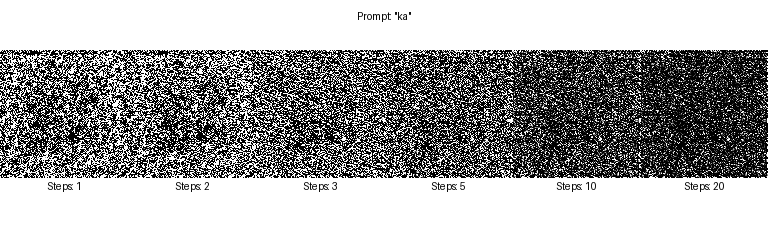

In [57]:
from diffusers import DPMSolverMultistepScheduler
import torch

# Initialize the model pipeline
pipeline = GlyffuserPipeline.from_pretrained("/content/multilingual_diffuser").to("cuda")
pipeline.scheduler = DPMSolverMultistepScheduler()

texts = ['ka']  # Your text prompt
num_inference_steps_list = [1, 2, 3, 5, 10, 20]  # List of different num_inference_steps values

images = []

# Generate images for each value in num_inference_steps_list
for num_steps in num_inference_steps_list:
    generated_images = pipeline(
        texts,
        batch_size=1,  # Generate one image at a time for each step
        generator=torch.Generator(device='cuda').manual_seed(42),  # Generator can be on GPU here
        num_inference_steps=num_steps
    ).images
    images.append(generated_images[0])  # Append the generated image

# Create the labeled grid
image_grid = make_labeled_grid(images, texts[0], num_inference_steps_list, font_size=30, margin=20)
image_grid

# Save the image grid
# image_grid.save(f"inference example.png") # Uncomment to save